c:\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting model training...
Epoch 1/5
688/688 - 11872s - 17s/step - accuracy: 0.9997 - loss: 0.0287 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 2/5
688/688 - 11551s - 17s/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 3/5
688/688 - 12324s - 18s/step - accuracy: 1.0000 - loss: 9.7210e-04 - val_accuracy: 1.0000 - val_loss: 4.8644e-04
Epoch 4/5
688/688 - 11596s - 17s/step - accuracy: 1.0000 - loss: 5.0872e-04 - val_accuracy: 1.0000 - val_loss: 2.7455e-04
Epoch 5/5
688/688 - 11965s - 17s/step - accuracy: 1.0000 - loss: 2.9957e-04 - val_accuracy: 1.0000 - val_loss: 1.6869e-04
Model training complete. Proceeding with evaluation.
172/172 ━━━━━━━━━━━━━━━━━━━━ 2478s 14s/step - accuracy: 1.0000 - loss: 1.6928e-04
Final Validation Loss: 0.0002
Final Validation Accuracy: 1.0000
Available history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


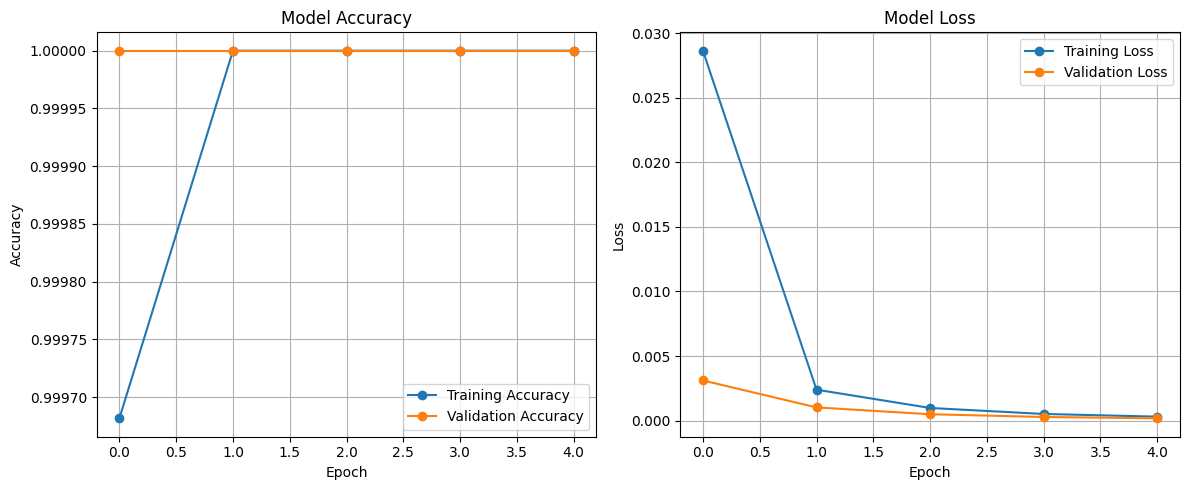

Training fold 1/5...


NameError: name 'tuner' is not defined

In [3]:
# Step 1: Import necessary libraries
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Load dataset
df = pd.read_csv(r'C:\Users\ksvsu\OneDrive\Desktop\Minor Project\Tweets.csv',
                 encoding='ISO-8859-1', header=None, on_bad_lines='skip')
df.columns = ['target', 'id', 'date', 'text']  # Adjust column names according to dataset

# Step 3: Simplify target labels (0 = negative, 4 = positive to binary 0 and 1)
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Step 4: Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data using the BERT tokenizer
def tokenize_tweets(tweets, tokenizer, max_length=128):
    return tokenizer(
        tweets.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

tokens = tokenize_tweets(df['text'], tokenizer)

# Prepare inputs for TensorFlow
input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']

# Convert TensorFlow tensors to NumPy arrays
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()
targets_np = df['target'].values

# Step 5: Split the data into training and validation sets
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids_np, attention_masks_np, targets_np,
    test_size=0.2, random_state=42, stratify=targets_np
)

# Step 6: Define a function to create TensorFlow datasets
def create_tf_dataset(inputs, masks, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': inputs, 'attention_mask': masks}, labels))
    return dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

batch_size = 32
train_dataset = create_tf_dataset(train_inputs, train_masks, train_labels, batch_size)
val_dataset = create_tf_dataset(val_inputs, val_masks, val_labels, batch_size)

# Step 7: Create a custom BERT model with additional layers
class CustomBERTModel(tf.keras.Model):
    def __init__(self, base_model):
        super(CustomBERTModel, self).__init__()
        self.base_model = base_model
        self.dropout = Dropout(0.3)
        self.classifier = Dense(2, activation='softmax')

    def call(self, inputs, training=False):
        outputs = self.base_model(inputs)
        pooled_output = outputs.pooler_output  # Use the pooled output for classification
        x = self.dropout(pooled_output, training=training)
        return self.classifier(x)

# Load pre-trained BERT and attach custom layers
base_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
model = CustomBERTModel(base_model.bert)

# Step 8: Define loss, optimizer, and metrics
loss_fn = SparseCategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=3e-5)  # Use a standard learning rate for fine-tuning BERT

# Step 9: Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Step 10: Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 11: Train the model with early stopping and exception handling
try:
    print("Starting model training...")
    history = model.fit(
        train_dataset,
        epochs=5,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        verbose=2  # Increase verbosity to get more details in the output
    )
    print("Model training complete. Proceeding with evaluation.")
except Exception as e:
    print(f"Error during model training: {e}")
    history = None  # Set history to None in case training fails

# Step 12: Evaluate the model
if history:
    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f"Final Validation Loss: {val_loss:.4f}")
    print(f"Final Validation Accuracy: {val_accuracy:.4f}")
else:
    print("Training failed. Cannot evaluate model.")

# Step 13: Plot the training and validation accuracy and loss
if history:
    # Check history keys to confirm available metrics
    print("Available history keys:", history.history.keys())
    
    # Plotting the accuracy and loss
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.figure(figsize=(12, 5))

        # Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("History object does not contain accuracy or loss data.")
else:
    print("No history object available. Skipping plotting.")
    from sklearn.model_selection import KFold
import numpy as np

# Define the number of folds for cross-validation
k_folds = 5

# Step 1: Initialize K-Fold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Step 2: Create lists to store scores for each fold
fold_accuracies = []
fold_losses = []

# Step 3: Perform K-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(input_ids_np)):
    print(f"Training fold {fold + 1}/{k_folds}...")
    
    # Split the data into training and validation for the current fold
    train_inputs_fold, val_inputs_fold = input_ids_np[train_index], input_ids_np[val_index]
    train_masks_fold, val_masks_fold = attention_masks_np[train_index], attention_masks_np[val_index]
    train_labels_fold, val_labels_fold = targets_np[train_index], targets_np[val_index]
    
    # Create datasets for the current fold
    train_dataset_fold = create_tf_dataset(train_inputs_fold, train_masks_fold, train_labels_fold)
    val_dataset_fold = create_tf_dataset(val_inputs_fold, val_masks_fold, val_labels_fold)

    # Build and compile the model for the current fold
    model = tuner.hypermodel.build(best_hps)
    
    # Train the model for this fold
    history = model.fit(
        train_dataset_fold,
        epochs=5,  # Reduce epochs for cross-validation (can increase if needed)
        validation_data=val_dataset_fold,
        verbose=2
    )
    
    # Evaluate the model on the validation set for this fold
    val_loss, val_accuracy = model.evaluate(val_dataset_fold, verbose=0)
    
    # Store the accuracy and loss for this fold
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)

    print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

# Step 4: Calculate mean and standard deviation of accuracy and loss across folds
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f"\nCross-Validation Results:")
print(f"Mean Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}")
import matplotlib.pyplot as plt

# Step 5: Plot the accuracy and loss for each fold
folds_range = np.arange(1, k_folds + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(folds_range, fold_accuracies, label='Validation Accuracy', marker='o')
plt.title('Cross-Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(folds_range, fold_losses, label='Validation Loss', marker='o', color='red')
plt.title('Cross-Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



In [2]:
from sklearn.model_selection import KFold
import numpy as np

# Define the number of folds for cross-validation
k_folds = 5

# Step 1: Initialize K-Fold
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Step 2: Create lists to store scores for each fold
fold_accuracies = []
fold_losses = []

# Step 3: Perform K-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(input_ids_np)):
    print(f"Training fold {fold + 1}/{k_folds}...")
    
    # Split the data into training and validation for the current fold
    train_inputs_fold, val_inputs_fold = input_ids_np[train_index], input_ids_np[val_index]
    train_masks_fold, val_masks_fold = attention_masks_np[train_index], attention_masks_np[val_index]
    train_labels_fold, val_labels_fold = targets_np[train_index], targets_np[val_index]
    
    # Create datasets for the current fold
    train_dataset_fold = create_tf_dataset(train_inputs_fold, train_masks_fold, train_labels_fold)
    val_dataset_fold = create_tf_dataset(val_inputs_fold, val_masks_fold, val_labels_fold)

    # Build and compile the model for the current fold
    model = tuner.hypermodel.build(best_hps)
    
    # Train the model for this fold
    history = model.fit(
        train_dataset_fold,
        epochs=5,  # Reduce epochs for cross-validation (can increase if needed)
        validation_data=val_dataset_fold,
        verbose=2
    )
    
    # Evaluate the model on the validation set for this fold
    val_loss, val_accuracy = model.evaluate(val_dataset_fold, verbose=0)
    
    # Store the accuracy and loss for this fold
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)

    print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

# Step 4: Calculate mean and standard deviation of accuracy and loss across folds
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f"\nCross-Validation Results:")
print(f"Mean Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Mean Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}")


Training fold 1/5...


NameError: name 'tuner' is not defined